In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

%matplotlib inline

import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

# redis keys
KOSPI_INDEX = 'I.001_INDEX'

KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [2]:
# 종가/거래량 데이터 불러오기
kp_ohlcv = pd.read_msgpack(r.get(KOSPI_OHLCV))
kd_ohlcv = pd.read_msgpack(r.get(KOSDAQ_OHLCV))

kp_vol = pd.read_msgpack(r.get(KOSPI_VOL))
kd_vol = pd.read_msgpack(r.get(KOSDAQ_VOL))

In [6]:
ohlcv = pd.concat([kp_ohlcv, kd_ohlcv], axis=1)
vol = pd.concat([kp_vol, kd_vol], axis=1)

In [7]:
# 거래대금 데이터 만들기
vol_prc = ohlcv * vol

# 수익률 데이터 만들기
ret = ohlcv.pct_change()

### Risk Parity

Target Volatility / Risk Parity: 각 종목이 포트폴리오에 기여하는 변동성의 양을 같게 만들어주는 전략

#### 현금 + 주식 전략

In [20]:
kp = pd.read_msgpack(r.get('I.001_INDEX'))
kp.index = pd.to_datetime(kp['date'])
kp_prc = kp['cls_prc']
kp_ret = kp_prc.pct_change()

bond = pd.read_msgpack(r.get('148070_OHLCV'))
bond.index = pd.to_datetime(bond['date'])
bond_prc = bond['adj_prc']
bond_ret = bond_prc.pct_change()

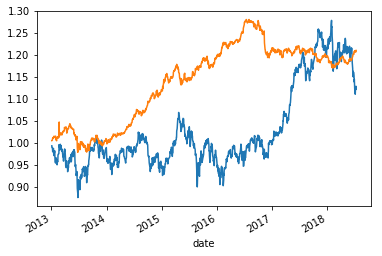

In [22]:
(1 + kp_ret).cumprod().plot()
(1 + bond_ret).cumprod().plot()

In [209]:
kp_std = kp_ret.rolling(200).std()
bond_std = bond_ret.rolling(200).std()
risk = kp_std + bond_std

kp_inv_amt = 1 - (kp_std / risk)
bond_inv_amt = 1 - (bond_std / risk)

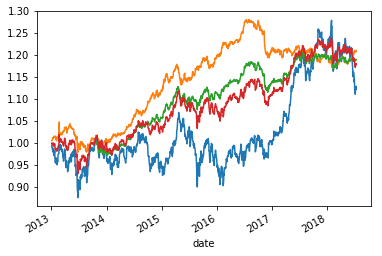

In [33]:
kp_port_ret = kp_ret * kp_inv_amt
bond_port_ret = bond_ret * bond_inv_amt
port_ret = kp_port_ret + bond_port_ret
port_50_ret = kp_ret * 0.5 + bond_ret * 0.5

(1 + kp_ret).cumprod().plot()
(1 + bond_ret).cumprod().plot()
(1 + port_ret).cumprod().plot()
(1 + port_50_ret).cumprod().plot()
plt.show()

### EAA (Elastic Asset Allocation): 상관관계 조절 전략

포트폴리오와의 상관관계를 최소화시켜서 분산 효과를 확실히 하기 위한 전략

In [131]:
## STEP 1:  동일비중 포트폴리오를 생성
port_50_ret = kp_ret * 0.5 + bond_ret * 0.5

In [132]:
corr = pd.DataFrame()
corr['KOSPI'] = kp_ret
corr['Bond'] = bond_ret
corr['50-50 Port'] = port_50_ret

In [133]:
corr = corr.rolling(200).corr()

In [134]:
kp_corr = corr.reset_index(level=[0, 1])[corr.reset_index(level=[0, 1])['level_1'] == '50-50 Port'][['date', 'KOSPI']]
kp_corr.set_index('date', inplace=True)

bond_corr = corr.reset_index(level=[0, 1])[corr.reset_index(level=[0, 1])['level_1'] == '50-50 Port'][['date', 'Bond']]
bond_corr.set_index('date', inplace=True)

In [141]:
corr_df = pd.DataFrame()
corr_df['KOSPI'] = kp_corr['KOSPI']
corr_df['Bond'] = bond_corr['Bond']
corr_df = 1 - corr_df

In [142]:
correlation = corr_df['KOSPI'] + corr_df['Bond']

kp_inv_amt = corr_df['KOSPI'] / correlation
bond_inv_amt = corr_df['Bond'] / correlation

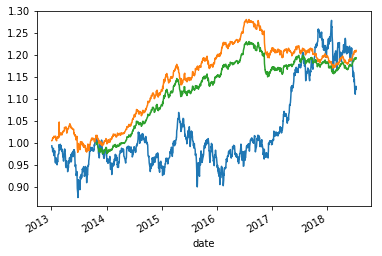

In [143]:
kp_port_ret = kp_ret * kp_inv_amt
bond_port_ret = bond_ret * bond_inv_amt
port_ret = kp_port_ret + bond_port_ret

(1 + kp_ret).cumprod().plot()
(1 + bond_ret).cumprod().plot()
(1 + port_ret).cumprod().plot()
plt.show()

### Momentum

In [147]:
def momentum(data):
    for i in range(1, 13):
        momentum = (data - data.shift(i)) / data.shift(i)
        momentum = (momentum > 0) * 1
        if i == 1:
            temp = momentum
        else:
            temp += momentum
    mom = temp
    return mom.fillna(0)  # nan은 0으로 처리

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


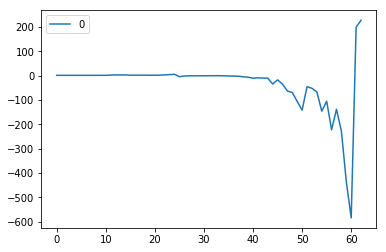

In [292]:
ret_list = []
tickers = ['005930', '006360', '000020', '030200', '000660']

mom = momentum(ohlcv.resample('M').last())
buy = mom >= 3

ohlcv_m = ohlcv.resample('M').last()[tickers]
ret_m = ohlcv_m.pct_change().fillna(0)
mom_m = mom[tickers]
buy_m = buy[tickers]

for date in range(len(ret)):
    try:
        invest_date = date + 1

        buy_index = buy_m.iloc[date][buy_m.iloc[date] == True].index

        # 상관관계 계산
        buy_ret_m = ret_m[buy_index]
        port_eq_wt_ret = (buy_ret_m * np.ones(len(buy_ret_m.columns)) * (1/len(buy_ret_m.columns))).sum(axis=1)
        buy_ret_m['Eq Wt Port'] = port_eq_wt_ret
        corr = buy_ret_m.rolling(12).corr()

        corr_df = pd.DataFrame()
        for ticker in buy_index:
            tmp_corr = corr.reset_index(level=[0, 1])[corr.reset_index(level=[0, 1])['level_1'] == 'Eq Wt Port'][['level_0', ticker]]
            tmp_corr.set_index('level_0', inplace=True)
            corr_df[ticker] = tmp_corr[ticker]

        # 변동성 계산
        std = ret_m.rolling(12).std()
        std['Risk'] = std.sum(axis=1)
        std = std.div(std['Risk'], axis='index')

        # EAA
        eaa = (1 - corr_df) / std[buy_index]

        eaa['sum'] = eaa.sum(axis=1)
        eaa.div(eaa['sum'], axis='index')
        eaa.drop('sum', axis=1, inplace=True)

        port_ret_row = ret_m.iloc[invest_date]
        invest_portion = eaa.iloc[date]
        port_ret = (port_ret_row * invest_portion).sum()

        ret_list.append(port_ret)
    except:
        continue
    
yc = pd.DataFrame(ret_list)
(1 + yc).cumprod().plot()
plt.show()

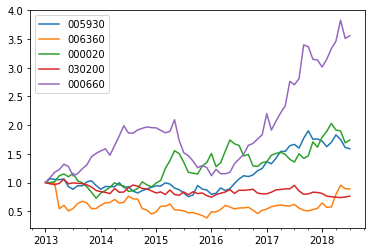

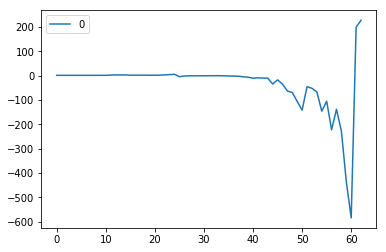

In [293]:
(1 + ret_m).cumprod().plot()
(1 + yc).cumprod().plot()